# EDA: Advanced Feature Extraction.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [2]:
df = pd.read_csv('train.csv')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [4]:
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    #removing non-word characters
    pattern = re.compile('\W')
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    porter = PorterStemmer()
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Token features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2
<br>        
- __last_word_eq__ :  Check if last word of both questions is equal or not
<br>
- __first_word_eq__ :  Check if first word of both questions is equal or not
<br>        
- __abs_len_diff__ :  Abs. length difference
<br>
- __mean_len__ :  Average Token Length of both Questions
<br>
<br>


Fuzzy features:

Description of the below fuzzy features: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/<br>
Usage of the FuzzyWuzzy library: https://github.com/seatgeek/fuzzywuzzy#usage

- __fuzz_ratio__ 
<br>
- __fuzz_partial_ratio__ 
<br>
- __token_sort_ratio__
<br>
- __token_set_ratio__ 
<br>
<br>


Other features:

- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [5]:
# To avoid division by zero
SAFE_DIV = 0.0001 


def get_token_features(q1,q2):
    token_features = [0.0]*10 #since there are ten token features as mentioned above
    
    #Converting the sentence into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    #Converting the tokens into words by removing duplicates and stopwords
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Getting the stopwords from the tokens
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #Getting the common word count from the question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    #Getting the common stopword count from the question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    #Getting the common token count from the question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    # Absolute length difference
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average token length
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

def get_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a,b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
def extract_features(df):
    df['question1'] = df['question1'].fillna('').apply(preprocess)
    df['question2'] = df['question2'].fillna('').apply(preprocess)
    
    token_features = df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)
    
    df['cwc_min'] = list(map(lambda x: x[0], token_features))
    df['cwc_max'] = list(map(lambda x: x[1], token_features))
    df['csc_min'] = list(map(lambda x: x[2], token_features))
    df['csc_max'] = list(map(lambda x: x[3], token_features))
    df['ctc_min'] = list(map(lambda x: x[4], token_features))
    df['ctc_max'] = list(map(lambda x: x[5], token_features))
    df['last_word_eq'] = list(map(lambda x: x[6], token_features))
    df['first_word_eq'] = list(map(lambda x: x[7], token_features))
    df['abs_len_diff'] = list(map(lambda x: x[8], token_features))
    df['mean_len'] = list(map(lambda x: x[9], token_features))
    
    #Computing Fuzzy Features and Merging with Dataset
    
    df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
    
    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis=1)
    
    return df


In [3]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv('nlp_features_train.csv')
    df = df.fillna('')
else:
    df = extract_features(df)
    df.to_csv('nlp_features_train.csv', index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,93,100,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,66,75,63,86,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [7]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

#Converting question1 and question2 into a 2d array, and flattening the array
p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten()

print('Number of duplicate pairs =', int(len(p)/2))
print('Number of non-duplicate pairs =', int(len(n)/2))
print('Total number of question pairs =', int(len(p)/2 + len(n)/2))

#Saving the numpy array of text into a .txt file
np.savetxt('train_p.txt', p, delimiter = ' ', fmt='%s', encoding = 'utf-8')
np.savetxt('train_n.txt', n, delimiter = ' ', fmt='%s', encoding = 'utf-8')

Number of duplicate pairs = 149263
Number of non-duplicate pairs = 255027
Total number of question pairs = 404290


**Note:** The whole point of saving the text file is to convert the numpy array into a single string, so that it's easier to process

In [4]:
d = os.path.dirname('.')

textp_w = open(os.path.join(d, 'train_p.txt'), encoding="utf-8").read()
textn_w = open(os.path.join(d, 'train_n.txt'), encoding="utf-8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w.split(" ")))
print ("Total number of words in non duplicate pair questions :",len(textn_w.split(" ")))

Total number of words in duplicate pair questions : 3049740
Total number of words in non duplicate pair questions : 6431216


In [7]:
#Replacing the stopwords with empty string
from tqdm import tqdm
cp = 0
for word in tqdm(textp_w.split(" ")):
    if word in stopwords:
        cp += 1
        textp_w = textp_w.replace(word, "")

100%|█████████████████████████████████████████████████████████████████████| 3049740/3049740 [2:25:13<00:00, 350.00it/s]


In [8]:
#Replacing the stopwords with empty string
from tqdm import tqdm
cn = 0
for word in tqdm(textn_w.split(" ")):
    if word in stopwords:
        cn += 1
        textn_w = textn_w.replace(word, "")

100%|█████████████████████████████████████████████████████████████████████| 6431216/6431216 [9:21:25<00:00, 190.92it/s]


In [9]:
print ("Total number of words in duplicate pair questions after removing stopwords :",len(textp_w.split(" ")))
print ("Total number of words in non duplicate pair questions after removing stopwords :",len(textn_w.split(" ")))

Total number of words in duplicate pair questions after removing stopwords : 3049740
Total number of words in non duplicate pair questions after removing stopwords : 6431216


<h3> WordCloud - Duplicate & Non-duplicate </h3>

WordCloud for Duplicate Question Pairs


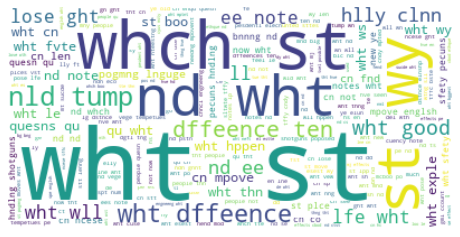

In [12]:
wc = WordCloud(background_color = 'white', max_words=len(textp_w))
wc.generate(textp_w)
print('WordCloud for Duplicate Question Pairs')
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

WordCloud for Non-duplicate Question Pairs


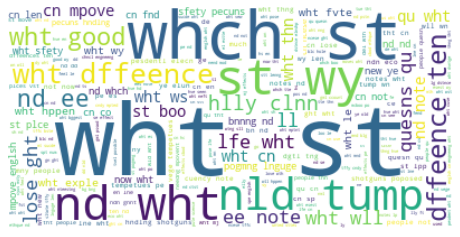

In [13]:
wc = WordCloud(background_color = 'white', max_words=len(textn_w))
wc.generate(textp_w)
print('WordCloud for Non-duplicate Question Pairs')
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

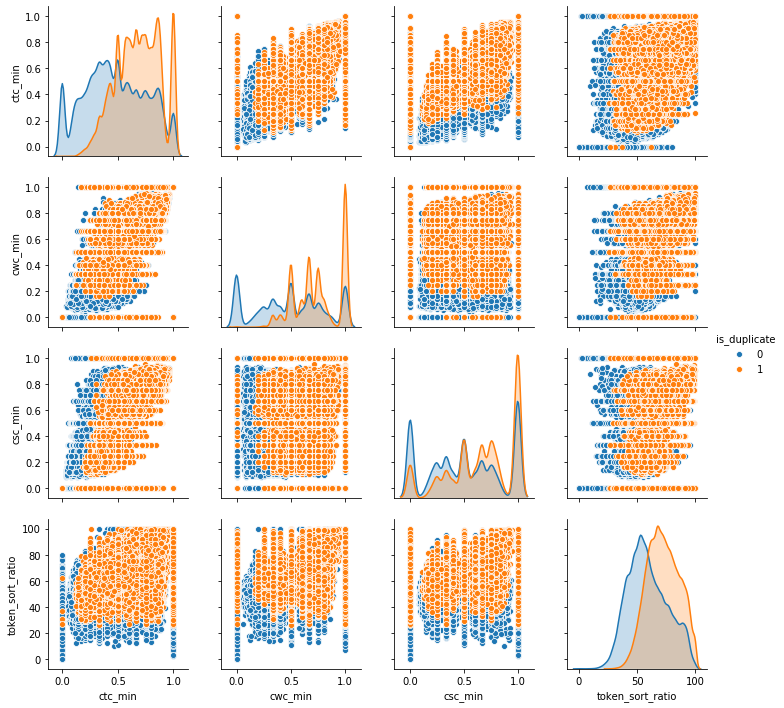

In [14]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], 
             hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

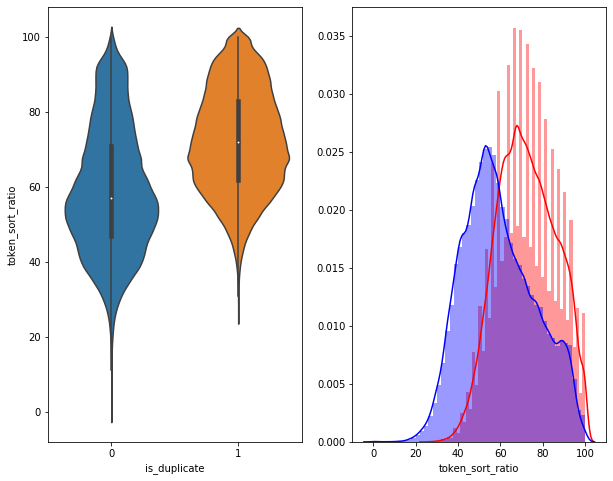

In [15]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

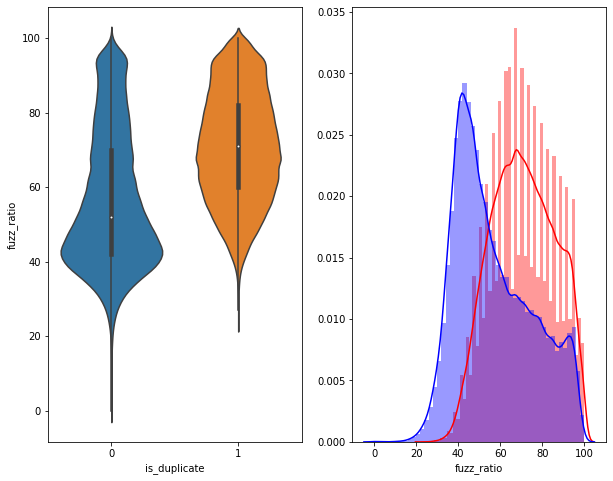

In [16]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [17]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [18]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.040s...
[t-SNE] Computed neighbors for 5000 samples in 0.887s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116497
[t-SNE] Computed conditional probabilities in 0.528s
[t-SNE] Iteration 50: error = 81.0385742, gradient norm = 0.0449765 (50 iterations in 3.832s)
[t-SNE] Iteration 100: error = 70.4079132, gradient norm = 0.0095674 (50 iterations in 2.973s)
[t-SNE] Iteration 150: error = 68.6164169, gradient norm = 0.0060152 (50 iterations in 3.053s)
[t-SNE] Iteration 200: error = 67.7438812, gradient norm = 0.0043398 (50 iterations in 2.987s)
[t-SNE] Iteration 250: error = 67.2491760, gradient norm = 0.0033025

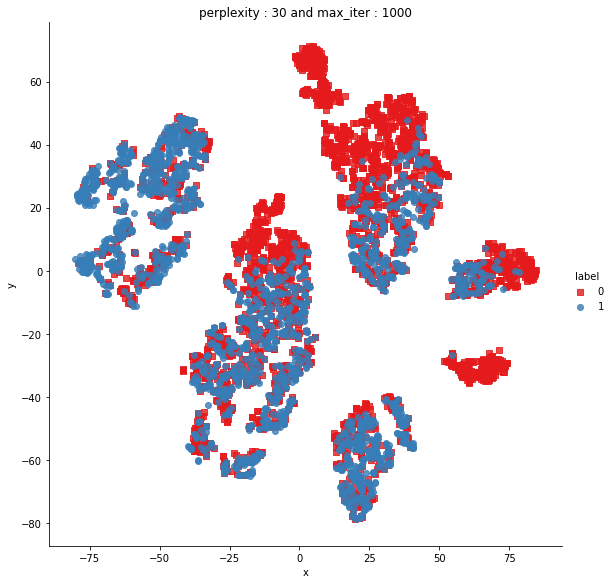

In [19]:
df_ = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_, x='x', y='y', hue='label', fit_reg=False, height=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [20]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.045s...
[t-SNE] Computed neighbors for 5000 samples in 0.859s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116497
[t-SNE] Computed conditional probabilities in 0.579s
[t-SNE] Iteration 50: error = 80.4330597, gradient norm = 0.0308409 (50 iterations in 7.763s)
[t-SNE] Iteration 100: error = 69.1565475, gradient norm = 0.0032417 (50 iterations in 5.602s)
[t-SNE] Iteration 150: error = 67.7022705, gradient norm = 0.0017471 (50 iterations in 5.231s)
[t-SNE] Iteration 200: error = 67.1103516, gradient norm = 0.0012643 (50 iterations in 5.064s)
[t-SNE] Iteration 250: error = 66.7844391, gradient norm = 0.0009249

In [21]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

**Observation:** After seeing the above plots, we can easily say that the extracted features are good for our classification problem. Although there is overlap, there are a few regions with completely blue points, or completely red points, which is a good sign.